# Participants’ agreement

- use Krippendorff’s alpha (Krippendorff, 1980) to measure inter-participants’ agreement
- the experiment is interpreted as an annotation task where participants (coders) annotate each triplets using single characters as labels
- to study within-participant agreement, use response entropy across participants

In [36]:
# intro, defaults (shared across notebooks)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import krippendorff

# ---------------------------------------------------
# set global properties for plotting

font = {"family":"Adapter Mono PE", "size":"10", "weight":"medium"}
figure = {"titlesize":"10","titleweight":"medium"}
axes = {"titlesize":"10", "titleweight":"medium", "labelsize":"10", "labelweight":"medium"}
plt.rc("font", **font)
plt.rc("figure", **figure)
plt.rc("axes", **axes)
COL = "black"
box_colors = dict(boxes=COL, whiskers=COL, medians=COL, caps=COL)

In [38]:
# Get data & fix types

# Tall data (a single response per row)
data = pd.read_csv("csv/raw-data-preprocessed_tall.csv", index_col=0, header=0, dtype="unicode")
data.sort_index(axis=1, inplace=True)
data["pid"] = data["pid"].astype("int")
data["order"] = data["order"].astype("float").astype("int")
#data["response"] = data["response"].astype("category")
data["fluent in script"] = (data["fluent in script"] == "True").astype("category")
data["native in script"] = (data["native in script"] == "True").astype("category")

# Wide data (all participant responses per row, lots of NA)
data_wide = pd.read_csv("csv/raw-data-preprocessed.csv", index_col=0, header=[0,1,2], dtype="unicode")
data_wide.sort_index(axis=1, inplace=True)

SCRIPTS = ["cyrillic", "devanagari", "latin"]
DESIGNERS = ["Graphic designer", "Typographer", "Other designer"]
TYPEFACES = {script: sorted(data[data["script"] == script]["typeface"].drop_duplicates().values) for script in SCRIPTS}
CHARS = sorted(data["response"].drop_duplicates().values)

In [51]:
#display(data)
pcount = len(data[data["order"] == 1]) // 56
scount = len(data) // 56
print(f"Imported {data.shape[0]} rows, {data.shape[1]} columns, {pcount} participants, {scount} sessions, 56 trial responses each.")

Imported 100072 rows, 14 columns, 1721 participants, 1787 sessions, 56 trial responses each.


In [5]:
from collections import Counter
from scipy.stats import entropy

def compute_entropy(responses):
    counts = Counter(responses)
    probs = [c / sum(counts.values()) for c in counts.values()]
    return entropy(probs, base=2)

# Compute entropy for each participant
edata = data.groupby("pid")["response"].apply(compute_entropy).reset_index()
edata.columns = ["pid", "entropy"]
# Merge entropy with participants’ data
demographic_data = data.drop_duplicates(subset=["pid"])
edata = pd.merge(edata, demographic_data, on="pid")
# Use data only from the first session
edata = edata[edata["order"] == 1]

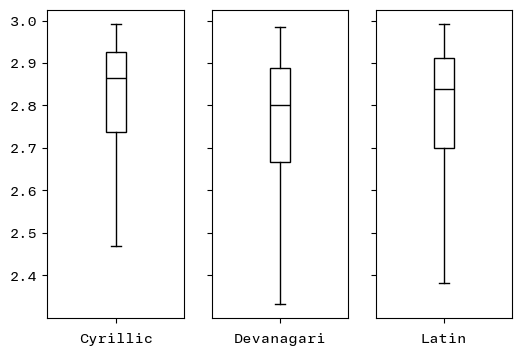

In [ ]:
# Entropy per script (box plots)

# report & plot multiple box plots next to each other
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0.2, hspace=0)
for i, script in enumerate(SCRIPTS):
  entropy_values = edata[edata["script"] == script]["entropy"]
  entropy_values.name = ""
  entropy_values.plot(kind="box",
                      patch_artist=True,
                      showfliers=False,
                      boxprops=dict(facecolor="white", color=COL),
                      color=box_colors,
                      xlabel=script.title(),
                      title="",
                      ax=axes[i],
                      )
fig.savefig("graphics/entropy_box-plots.pdf", bbox_inches="tight")

In [58]:
# Krippendorff’s alpha and entropy per script and typeface

COLS = ["Typeface", "Alpha", "Entropy"]

for script in SCRIPTS:
  print(script.title())
  results = pd.DataFrame(columns=COLS)
  for typeface in TYPEFACES[script]:
    tdata = pd.DataFrame(data_wide[(script, typeface,)].dropna(how="all"))
    for c in tdata.columns:
      tdata[c] = [np.nan if pd.isnull(v) else CHARS.index(v) for v in tdata[c].values]
    alpha = krippendorff.alpha(reliability_data=tdata.values, level_of_measurement='nominal')
    entropy = edata[(edata["script"] == script) & (edata["typeface"] == typeface)]["entropy"].mean()
    results.loc[len(results), COLS] = [typeface, alpha.round(2), entropy.round(2)]
    #print(f"- {typeface}: {alpha:.2f}")
  
  # overall results
  sdata = pd.DataFrame(data_wide[(script,)].dropna(how="all"))
  for c in sdata.columns:
    sdata[c] = [np.nan if pd.isnull(v) else CHARS.index(v) for v in sdata[c].values]
  alpha = krippendorff.alpha(reliability_data=sdata.values, level_of_measurement="nominal")
  entropy = edata[edata["script"] == script]["entropy"].mean()
  results.loc[len(results), COLS] = ["Overall", alpha.round(2), entropy.round(2)]
  display(results)
  results.to_csv(f"csv/participants-agreement_{script}.csv")

Cyrillic


,Typeface,Alpha,Entropy
0,arial,0.47,2.84
1,century-schoolbook,0.5,2.8
2,courier-new,0.51,2.81
3,georgia,0.51,2.82
4,pt-sans,0.6,2.8
5,pt-serif,0.46,2.86
6,times-new-roman,0.53,2.85
7,verdana,0.44,2.65
8,Overall,0.56,2.81


Devanagari


,Typeface,Alpha,Entropy
0,adobe-devanagari,0.36,2.75
1,devanagari-mt,0.39,2.77
2,ek-mukta,0.42,2.66
3,itf-devanagari,0.41,2.71
4,kohinoor-devanagari,0.51,2.88
5,lohit-devanagari,0.4,2.71
6,murty-hindi,0.42,2.81
7,nirmala-ui,0.41,2.8
8,Overall,0.48,2.76


Latin


,Typeface,Alpha,Entropy
0,arial,0.51,2.81
1,calibri,0.56,2.82
2,cambria,0.55,2.71
3,candara,0.56,2.88
4,century-schoolbook,0.54,2.81
5,courier-new,0.58,2.88
6,futura,0.59,2.77
7,georgia,0.56,2.85
8,pt-sans,0.53,2.69
9,pt-serif,0.5,2.69


In [ ]:
# if the distribution is non-normal -> cannot use ANOVA or t-test

pg.normality(edata, group="fluent in script", dv="entropy")

,W,pval,normal
fluent in script,,,
True,0.879936,1.329958e-33,False
False,0.941602,1.654911e-04,False


In [ ]:
# Using the Mann Whitney U-statistic instead.
# If the p-value is <0.05 we reject the null hypothesis
# that there is no difference in entropy means

from scipy.stats import mannwhitneyu

for script in SCRIPTS:
  print(f"\n{script.title()}")
  for group, values in [
    ("fluent in script", (True, False)),
    ("native in script", (True, False)),
    ("design skills", ("Non-designer", DESIGNERS)),
    ("design skills", ("Letter designer", DESIGNERS)),
    ("design skills", ("Non-designer", "Letter designer")),
    ("design skills", ("Non-designer", ALLDESIGNERS)),
  ]:
    conditions = [(edata["script"] == script), (edata["script"] == script)]
    for i, v in enumerate(values):
      if isinstance(v, (list, tuple)):
        conditions[i] = conditions[i] & (edata[group].isin(v))
      else:
        conditions[i] = conditions[i] & (edata[group] == v)
    groups = [edata[c]["entropy"] for c in conditions]
    print(f"{group} ({values[0]} ({len(groups[0])}) vs. {values[1]} ({len(groups[1])}))")
    u, p_val = mannwhitneyu(*groups, alternative="two-sided")
    print(f"> Mann Whitney U-statistic: {u:.2f}, p-value: {p_val:.3f}")



Cyrillic
fluent in script (True (482) vs. False (27))
> Mann Whitney U-statistic: 8236.50, p-value: 0.020
native in script (True (472) vs. False (37))
> Mann Whitney U-statistic: 9745.00, p-value: 0.240
design skills (Non-designer (361) vs. ['Graphic designer', 'Typographer', 'Other designer'] (121))
> Mann Whitney U-statistic: 25258.00, p-value: 0.010
design skills (Letter designer (27) vs. ['Graphic designer', 'Typographer', 'Other designer'] (121))
> Mann Whitney U-statistic: 1711.00, p-value: 0.702
design skills (Non-designer (361) vs. Letter designer (27))
> Mann Whitney U-statistic: 5485.50, p-value: 0.277
design skills (Non-designer (361) vs. ['Letter designer', 'Graphic designer', 'Typographer', 'Other designer'] (148))
> Mann Whitney U-statistic: 30743.50, p-value: 0.008

Devanagari
fluent in script (True (356) vs. False (76))
> Mann Whitney U-statistic: 13723.00, p-value: 0.844
native in script (True (259) vs. False (173))
> Mann Whitney U-statistic: 23387.50, p-value: 0.439

In [9]:
import statsmodels.formula.api as smf

# prepare columns for statsmodels/R notation
edata["script"] = edata["script"].astype("category")
edata["fluent_in_script"] = edata["fluent in script"].astype("category")
edata["native_in_script"] = edata["native in script"].astype("category")

model = smf.ols("entropy ~ fluent_in_script + script", data=edata).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                entropy   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     7.031
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           0.000107
Time:                        15:08:00   Log-Likelihood:                 619.48
No. Observations:                1721   AIC:                            -1231.
Df Residuals:                    1717   BIC:                            -1209.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               